# Import libraries

In [1]:
import pandas as pd
from unidecode import unidecode
import re
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

# Import data

In [2]:
formatted_offers = pd.read_json("./data/formated_offers.json", orient="records")
# Cast to list of dicts
formatted_offers = formatted_offers.to_dict('records')

# Read INFOJOBS_ESTUDIOS dataset

In [4]:
df = pd.read_json("./archives/INFOJOBS_ESTUDIOS.json")
# Clean df
df = df[df['nivel'] != "(Seleccionar)"]
# Read expection_list.txt
with open("./archives/expection_list.txt", 'r') as f:
    expection_list = f.read().splitlines()


def format_denominacion(denominacion):
    for expection in expection_list:
        if expection in denominacion:
            denominacion = denominacion.replace(expection, "")
    return unidecode(denominacion).lower().strip()


df["nivel_formated"] = df["nivel"].apply(format_denominacion)
df["denominacion_formated"] = df["denominacion"].apply(format_denominacion)
# Read id_to_nivel.json
df_id = pd.read_json("./archives/id_to_nivel.json")
# Apply the format_denominacion function to the column 'nivel' of df_id
df_id['nivel_formated'] = df_id['nivel'].apply(format_denominacion)
id_to_titulacion = dict(zip(df_id['id'], df_id['nivel_formated']))
id_to_titulacion_raw = dict(zip(df_id['id'], df_id['nivel']))
# Create a dictionary to cast from 'denominacion_formated' to 'denominacion'
niveles_df = pd.read_json("./archives/niveles_estudio.json")
niveles_df['denominacion_formated'] = niveles_df['denominacion'].apply(
    format_denominacion)
# Cast from df to dict key: denominacion, value: nivel
denominacion_to_id_nivel = {}
for denominacion, group in niveles_df.groupby('denominacion_formated'):
    denominacion_to_id_nivel[denominacion] = int(group['id_nivel'].tolist()[0])
# Create a dictionary
denominacion_to_titulacion = {}
for denominacion, group in df.groupby('denominacion_formated'):
    denominacion_to_titulacion[denominacion] = group['nivel_formated'].tolist()
# Create a dictionary
id_nivel_to_titulacion = {}
for id_nivel, group in df.groupby('id_nivel'):
    id_nivel_to_titulacion[id_nivel] = group['nivel_formated'].tolist()
id_nivel_to_id = {}
for id_nivel, group in df.groupby('id_nivel'):
    id_nivel_to_id[id_nivel] = group['id'].tolist()


# Load custom correlations

In [5]:
def read_property_correlations(file_path, correlations, option='niveles'):
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('->')
            property_name = parts[0]
            corresponding_parts = parts[1].split(',')
            # Check if the property already exists in correlations
            correlations[property_name] = []
            for corresponding_part in corresponding_parts:
                if property_name not in correlations:
                    continue
                if option == 'niveles':
                    correlations[property_name].append(correlations[corresponding_part])
                elif option == 'titles':
                    correlations[property_name].extend(correlations[corresponding_part])
    try:
        del correlations['grado']
    except:
        print("Already deleted grado")
    return correlations

# Example usage:
file_path = './archives/correlations.txt'
denominacion_to_id_nivel = read_property_correlations(file_path, denominacion_to_id_nivel, option='niveles')
denominacion_to_titulacion = read_property_correlations(file_path, denominacion_to_titulacion, option='titles')

# Test search function

In [5]:
def get_niveles(niveles, description):
    obteined_niveles = []
    for nivel in niveles.keys():
        pattern = r'\b' + re.escape(nivel) + r'\b'
        if re.search(pattern, description):
            obteined_niveles.append(nivel)
    return obteined_niveles


def get_id_titulo(obteined_titles, mapping_id, id_nivel_to_id):
    id_titulos = []
    for title in obteined_titles:
        id_nivel = title['id_nivel']
        ids = id_nivel_to_id[id_nivel]
        titulo = title['titulo']
        for id in ids:
            if id in mapping_id:
                if titulo == mapping_id[id]:
                    id_titulos.append(id)
    return id_titulos


def get_titulo(description, numerical_niveles, id_nivel_to_titulacion):
    # Get all the possible titulaciones from id_nivel_to_titulacion with the numerical_niveles
    obteined_titles = []
    for nivel in numerical_niveles:
        if nivel in id_nivel_to_titulacion:
            titulos = id_nivel_to_titulacion[nivel]
            for titulo in titulos:
                pattern = r'\b' + re.escape(titulo) + r'\b'
                if re.search(pattern, description):
                    obteined_titles.append(
                        {'id_nivel': nivel, 'titulo': titulo})
    return obteined_titles


def add_nivel_to_offer(denominacion_to_id_nivel, obteined_niveles):
    # Find for each nivel the corresponding id
    numerical_niveles = []
    for nivel in obteined_niveles:
        # Denonimacion_to_id_nivel[nivel] can be a int or a list of ints
        if isinstance(denominacion_to_id_nivel[nivel], int):
            numerical_niveles.append(denominacion_to_id_nivel[nivel])
        else:
            numerical_niveles.extend(denominacion_to_id_nivel[nivel])
    # Delete repeated values
    numerical_niveles = list(set(numerical_niveles))
    return numerical_niveles


def get_min_and_max_nivel(offer):
    if len(offer['numerical_niveles']) == 1:
        return offer['numerical_niveles'][0], offer['numerical_niveles'][0]
    return min(offer['numerical_niveles']), max(offer['numerical_niveles'])


def verify_grado(titles, description, N=15):
    # Get the index of the word "grado" in the description
    index = description.find("grado")
    # Get the N words before and after the word "grado" in the description
    words = description[index-N:index+N]
    # Verify if the obtained titles are in the words
    for title in titles["grado"]:
        if title in words:
            return True
    return False

def insert_raw_titles(obteined_titles, mapping_id_raw):
    raw_titles = []
    for title in obteined_titles:
        raw_titles.append(mapping_id_raw[title])
    return raw_titles

def normalize_offer(denominacion_to_id_nivel, titulacion_to_id, id_to_titulacion_raw, id_nivel_to_titulacion, id_nivel_to_id, offer, estrict=False):
    description = unidecode(offer['description']).lower()
    # Verify if the offer description have "Requisitos"
    if estrict:
        if "requisitos" not in description:
            return offer
        description = description[description.find("requisitos"):]
    obteined_niveles = get_niveles(denominacion_to_id_nivel, description)
    if len(obteined_niveles) > 0:
        offer['denominacion_nivel'] = obteined_niveles
        offer['numerical_niveles'] = add_nivel_to_offer(
            denominacion_to_id_nivel, obteined_niveles)
        offer['min_nivel'], offer['max_nivel'] = get_min_and_max_nivel(offer)
        # TODO: Filter description by finded denominacion_nivel and get words before and after
        obteined_titles = get_titulo(
            description, offer['numerical_niveles'], id_nivel_to_titulacion)
        if len(obteined_titles) > 0:
            offer['id_titulos'] = get_id_titulo(
                obteined_titles, titulacion_to_id, id_nivel_to_id)
            offer['titulos_raw'] = insert_raw_titles(
                offer['id_titulos'], id_to_titulacion_raw)
    return offer

def normalize_to_infojobs_offer(denominacion_to_id_nivel, titulacion_to_id, id_to_titulacion_raw, id_nivel_to_titulacion, id_nivel_to_id, formatted_offers):
    for index, offer in enumerate(tqdm(formatted_offers, desc="Processing offers")):
        formatted_offers[index] = normalize_offer(denominacion_to_id_nivel, titulacion_to_id,
                                    id_to_titulacion_raw, id_nivel_to_titulacion, id_nivel_to_id, offer, estrict=False)
    return formatted_offers

offers = normalize_to_infojobs_offer(
    denominacion_to_id_nivel, id_to_titulacion, id_to_titulacion_raw, id_nivel_to_titulacion, id_nivel_to_id, formatted_offers)

Processing offers:   0%|          | 0/894 [00:00<?, ?it/s]

Processing offers: 100%|██████████| 894/894 [00:10<00:00, 83.89it/s] 


In [6]:
# Cast to df and save to json line by line
df = pd.DataFrame(offers)
df.to_json("./test/offers_nacional_enero_2023.json", orient="records", lines=True)

# Métricas de test

In [7]:
# Calculate all offers with 'denominacion_nivel'
offers_denominacion = []
for offer in offers:
    if 'denominacion_nivel' in offer:
        offers_denominacion.append(offer)
# Calculate all offers with 'titulos_raw'
offers_titulos = []
for offer in offers:
    if 'titulos_raw' in offer:
        offers_titulos.append(offer)
print("Total de ofertas: ", len(offers))
print("Ofertas con denominación: ", len(offers_denominacion))
print("Ofertas con título: ", len(offers_titulos))
percentage_denominacion = len(offers_denominacion) / len(offers) * 100
percentage_titulos = len(offers_titulos) / len(offers) * 100
print("Porcentaje sobre el total de ofertas con denominación: {:.2f}%".format(percentage_denominacion))
print("Porcentaje sobre el total de ofertas con titulación: {:.2f}%".format(percentage_titulos))


Total de ofertas:  894
Ofertas con denominación:  246
Ofertas con título:  147
Porcentaje sobre el total de ofertas con denominación: 27.52%
Porcentaje sobre el total de ofertas con titulación: 16.44%


Total ofertas:  894
Total ofertas encontradas:  147
Porcentaje: 16.44%
{'grado en': 42, 'o grado': 23, 'licenciatura': 22, 'grado medio': 22, 'titulacion universitaria': 19, 'grado superior': 18, 'master': 17, 'diplomatura': 15, 'ciclo formativo': 13, 'fp': 13, 'formacion profesional': 10, 'grado o': 9, 'licenciado': 8, 'grado medio o superior': 7, 'ingenieria tecnica': 7, 'grado universitario': 7, 'graduado': 7, 'bachillerato': 4, 'postgrado': 3, 'ciclo superior': 2, 'formacion profesional grado medio': 1, 'ciclo formativo grado superior': 1, 'educacion secundaria obligatoria': 0, 'educacion secundaria': 0, 'formacion profesional grado superior': 0, 'ciclo formativo grado medio': 0, 'diplomado': 0, 'doctorado': 0, 'ingenieria superior': 0}


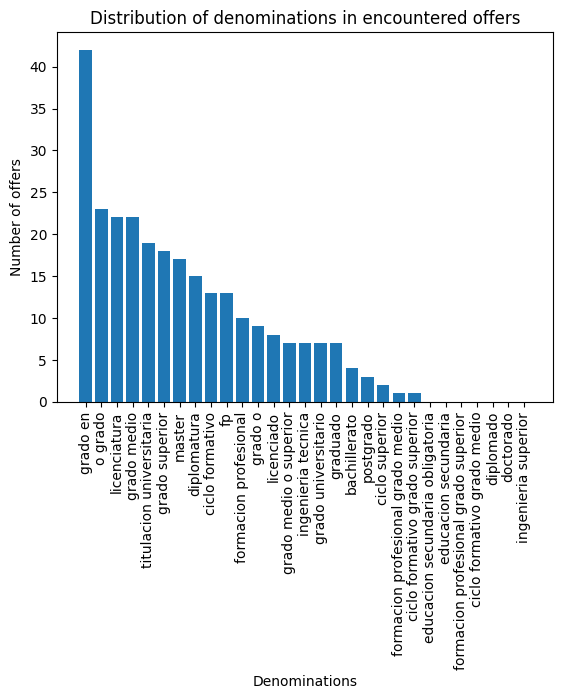

In [8]:
# Get all the offers with "denominacion" and "titulo"
test_offers = [offer for offer in offers if 'titulos_raw' in offer]
print("Total ofertas: ", len(offers))
print("Total ofertas encontradas: ", len(test_offers))
# print the porcentage of offers with "denominacion" and "titulo"
percentage = len(test_offers) / len(offers) * 100
print("Porcentaje: {:.2f}%".format(percentage))
# Print how many offers detect in test_offers for each denominacion
obtained_denominations = {}
for offer in test_offers:
    for denomination in offer['denominacion_nivel']:
        if denomination not in obtained_denominations:
            obtained_denominations[denomination] = 0
        else:
            obtained_denominations[denomination] += 1
# Sort by values
obtained_denominations = dict(sorted(obtained_denominations.items(), key=lambda item: item[1], reverse=True))
# And plot the results, in a bar plot
plt.bar(obtained_denominations.keys(), obtained_denominations.values())
plt.title("Distribution of denominations in encountered offers")
plt.xlabel("Denominations")
plt.ylabel("Number of offers")
plt.xticks(rotation=90)
print(obtained_denominations)

# Clasified

In [9]:
# Assuming correct is a list of dictionaries
correct = [offer for offer in test_offers if 'denominacion_nivel' in offer]

# Function to make a dictionary JSON serializable
def make_serializable(obj):
    if isinstance(obj, pd.Timestamp):
        return obj.strftime("%Y-%m-%d %H:%M:%S")  # Convert Timestamp to string
    else:
        return obj

# Make the "date" property JSON serializable
for offer in correct:
    if 'date' in offer:
        offer['date'] = make_serializable(offer['date'])

# Save the corrected offers to JSON
with open("./data/correct_offers.json", 'w') as f:
    json.dump(correct, f, indent=4)


# Errors

In [10]:
# Get the registers without "denominacion_nivel"
errors = [offer for offer in offers if 'denominacion_nivel' not in offer]

# Make the "date" property JSON serializable
for offer in errors:
    if 'date' in offer:
        offer['date'] = make_serializable(offer['date'])

# Save the corrected offers to JSON
with open("./data/errors.json", 'w') as f:
    json.dump(errors, f, indent=4)